# Tree Search in AI and Visualization  
### Xian Lai
xlai4@fordham.edu

=======================================================
![](images/cover.jpg)

Searching is one of the most flexible way to deal with problem that can't be solved directly and exactly. By systematically exploring the state space, we will eventually reach the goal state we are looking for. If what we are interested is the path from initial state to goal state, then we need to save the states and orders we explored in a tree structure. 

This small project includes implementation of a general tree search algorithm module that can employ different searching strategies like depth-first search, iterative deepening search, A* search etc. and a visualization module that can visualize the result search tree nicely.

And we will illustrate how to use these 2 modules through an example problem--Romania road trip problem described in Stuart Russell and Peter Norvig's book [Artificial Intelligence: a Modern Approach, 2010].

### Example problem:

In the problem we are given a simplified city map of Romania with distances between each pair of cities reachable from each other(fig 3.2) and the straight line distances from each city to Bucharest(fig 3.22). Suppose an agent is in Arad and has to find a shortest way to reach Bucharest. What is the best path for it? 

<img src="images/RomaniaRoadMap.png" alt="Romania road map" style="width: 600px;"/>
<img src="images/SLD.png" alt="Straight line distance to Burcherest" style="width: 600px;"/>

---
references:
- title: Artificial Intelligence: a Modern Approach.
- author:
  - Russell, Stuart J.
  - Peter Norvig
- publisher: Prentice-Hall
- issued: 2010
---

### Modules:
- **TreeSearch.py**
    This module implements the general tree search class that performs basic operations like expand node, evaluate state, append new nodes to tree as well as searching strategies like depth first search, breath first search and so on.
 
- **RoadtripProblem.py**
    This module implements the example Romania roadtrip problem that mainly contains the transition model, the heuristic function and the method to check goal.
    
- **TreeVisual.py**
    This module plots the search tree in a polar coordinates.
    
For more detail informations about the attributes and methods of these modules, please look at the **Documentations.md** file.

In [1]:
from TreeSearch import TreeSearch
from RoadtripProblem import RoadtripProblem
from TreeVisual import PolarPlot
%matplotlib inline

### 1. Tree Search
Because the specific problem class is the child class of tree search and the tree visual class is used in the tree search class. We can directly perform searching and visualization using the specific problem class.

The plotting puts the initial state in the center and spread the layers of successors outward. Each node is colored by their path cost and the edge on the path together with the label of goal nodes are colored in green.

Let's say we want to go to city Bucharest from city Arad.

In [2]:
params = {
    'initState':'Arad', 
    'goalState':'Bucharest'
}

#### uniformCostSearch(maxNodes=100)
We first initialize the problem instance with initstate and goalstate as inputs. Then we perform uniform cost search. At last we can use the plot_tree method to plot the result seach tree.

\* For now the visualization is not smart enough to choose the appropriate figure size to lay out the tree nicely. You may need to find the best value. 

UCS search begins:
the search will stop when 100 nodes or             
every nodes in infinite generations are discovered
Search ends


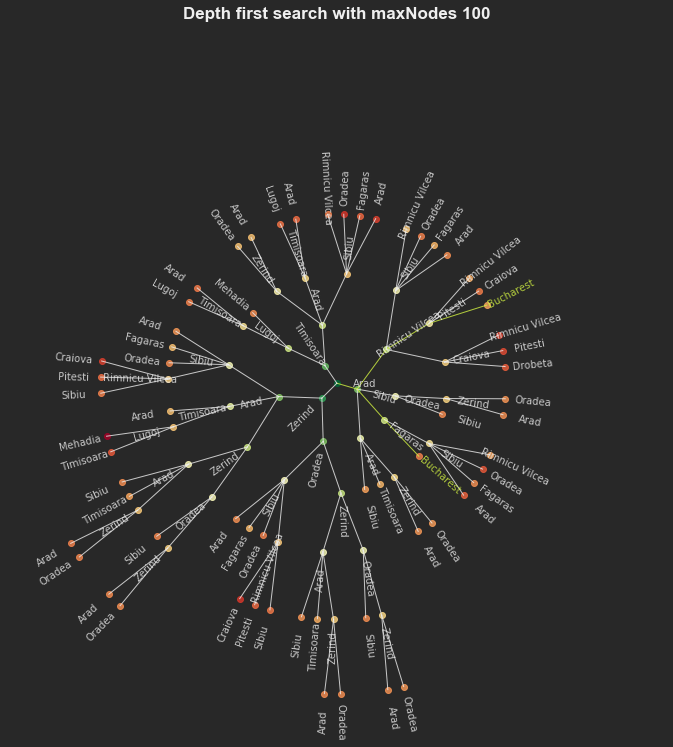

In [3]:
problem = RoadtripProblem(**params)
# The maxNodes parameter will tell the search algorithm
# to stop when the number of nodes reaches 100. For more
# details, please look at the documentation file.
problem.uniformCostSearch(maxNodes=100)
problem.plot_tree(
    diameter=12, ls='-', a=0.8,
    title='Depth first search with maxNodes 100'
)

#### depthFirstSearch & show_progress =True
If we set show_progress to True when initializing the RoadtripProblem instance, the search will print out which node it is expanding now and what are the currently total number of nodes, layers and paths. This is helpful in debugging.

In [4]:
problem = RoadtripProblem(show_progress=True, **params)
problem.depthFirstSearch(maxNodes=10)

DFS search begins:
the search will stop when 10 nodes or             
every nodes in infinite generations are discovered

now expanding: generation:(0); clst:(0); sibl:(0); state:(Arad)
total number of nodes : 1, 
total number of layers : 0,            
number of paths found : 0

now expanding: generation:(1); clst:(0); sibl:(2); state:(Zerind)
total number of nodes : 4, 
total number of layers : 2,            
number of paths found : 0

now expanding: generation:(1); clst:(0); sibl:(1); state:(Timisoara)
total number of nodes : 6, 
total number of layers : 3,            
number of paths found : 0

now expanding: generation:(1); clst:(0); sibl:(0); state:(Sibiu)
total number of nodes : 8, 
total number of layers : 3,            
number of paths found : 0
Search ends


#### breadthFirstSearch & background ='light'
If we set the kwarg background to 'light', then the plot will use the lighter background and darker color for edges and labels.

BFS search begins:
the search will stop when infinite nodes or             
every nodes in 5 generations are discovered
Search ends


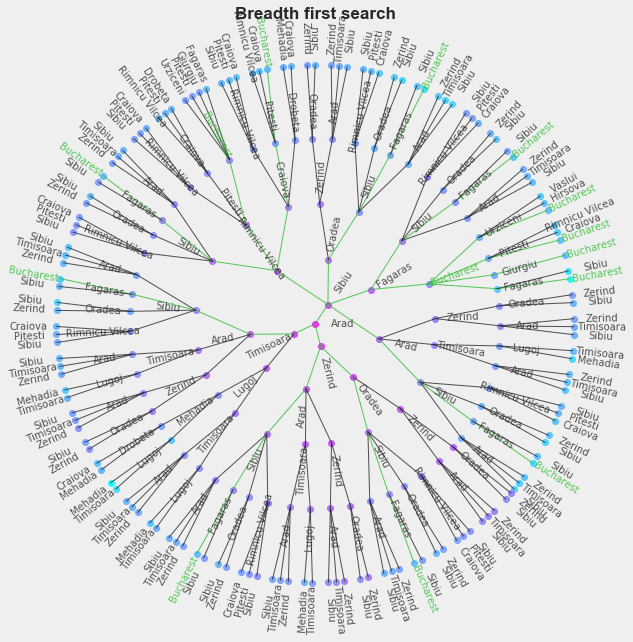

In [5]:
problem = RoadtripProblem(**params)
problem.breadthFirstSearch(maxLayers=5)
problem.plot_tree(
    diameter=10, ls='-', a=0.8, background='light',
    title='Breadth first search'
)

#### iterativeDeepeningSearch(maxDepth=5) & print_paths()
We can perform iterative deepening search which is simply depth first search with increasing depth limit. The maxDepth parameter is the maximal depth allowed and the search will stop early when goal is found. 

After searching, we can choose to print out the paths found. The real paths saved are nested list of nodes, and what will be print out are the informtion extracted from each node.    
[path_0, path_1, ...]    
 path_# = [   
 {'action':action_0, 'state':state_0, 'pathCost':pathCost_0},     
 {'action':action_1, 'state':state_1, 'pathCost':pathCost_1},    
 ...    
 ]

In [6]:
problem = RoadtripProblem(**params)
problem.iterativeDeepeningSearch(maxDepth=5)
problem.print_paths()

DFS search begins:
the search will stop when infinite nodes or             
every nodes in 1 generations are discovered
Search ends
DFS search begins:
the search will stop when infinite nodes or             
every nodes in 2 generations are discovered
Search ends
DFS search begins:
the search will stop when infinite nodes or             
every nodes in 3 generations are discovered
Search ends

1 paths found:
[[{'action': 'initialize', 'pathCost': 0, 'state': 'Arad'},
  {'action': 'go Sibiu', 'pathCost': 140.0, 'state': 'Sibiu'},
  {'action': 'go Fagaras', 'pathCost': 239.0, 'state': 'Fagaras'},
  {'action': 'go Bucharest', 'pathCost': 450.0, 'state': 'Bucharest'}]]


#### bestFirstSearch(maxNodes=30)

bestFS search begins:
the search will stop when 30 nodes or             
every nodes in infinite generations are discovered
Search ends


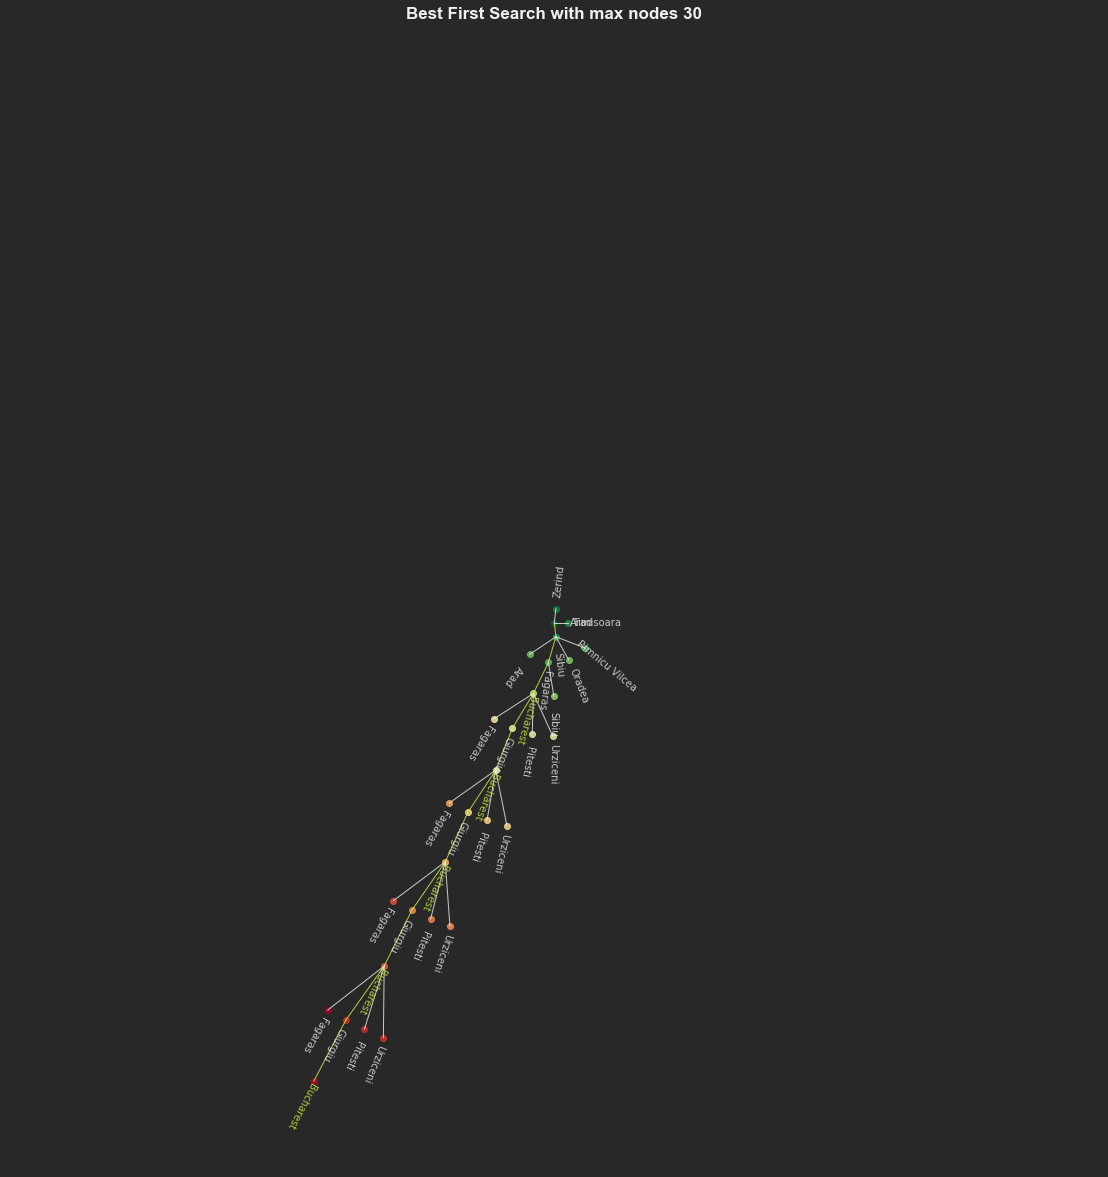

In [7]:
problem = RoadtripProblem(**params)
problem.bestFirstSearch(maxNodes=30)
problem.plot_tree(
    diameter=20, title="Best First Search with max nodes 30"
)

#### aStarSearch(maxNodes=500) & export()
When performing A star search, we are using both heuristic and path cost as our guidance towards the goal node. 

Finally, we can choose to write the searching result as JSON file in current directory by method problem.export().

aStar search begins:
the search will stop when 500 nodes or             
every nodes in infinite generations are discovered
Search ends


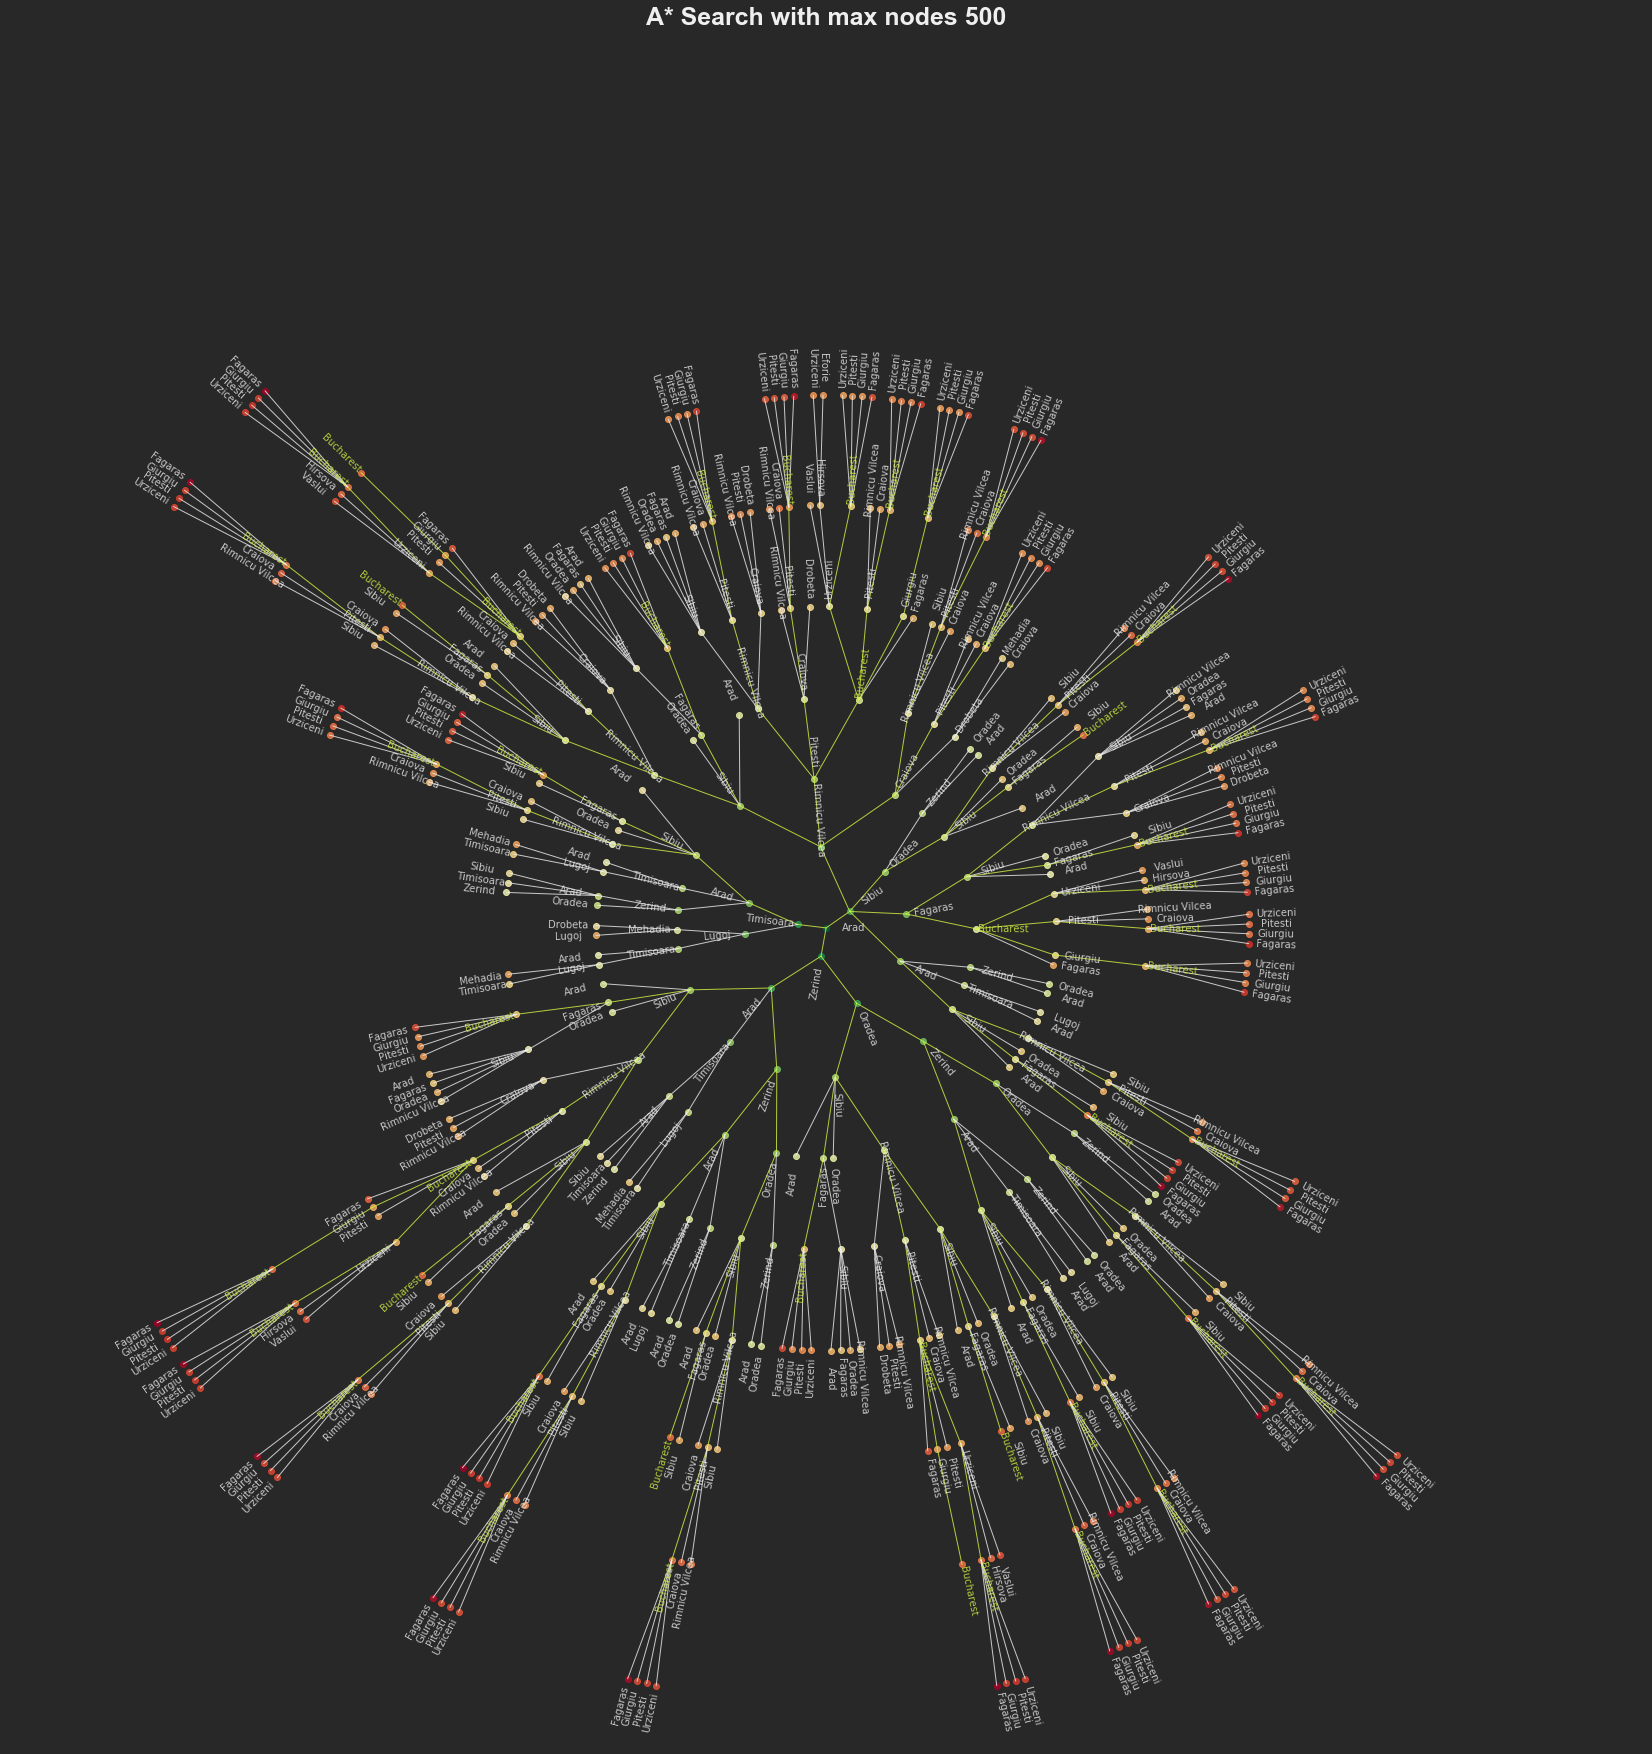

In [8]:
problem = RoadtripProblem(**params)
problem.aStarSearch(maxNodes=500)
problem.plot_tree(
    diameter=30, title="A* Search with max nodes 500"
)
problem.export()

### 2. Tree Visual
We can only choose to use the TreeVisual module if we already have the tree. But this requires the tree to have the same format and information as the result of TreeSearch module. For the details of required format, please look at the documentation.

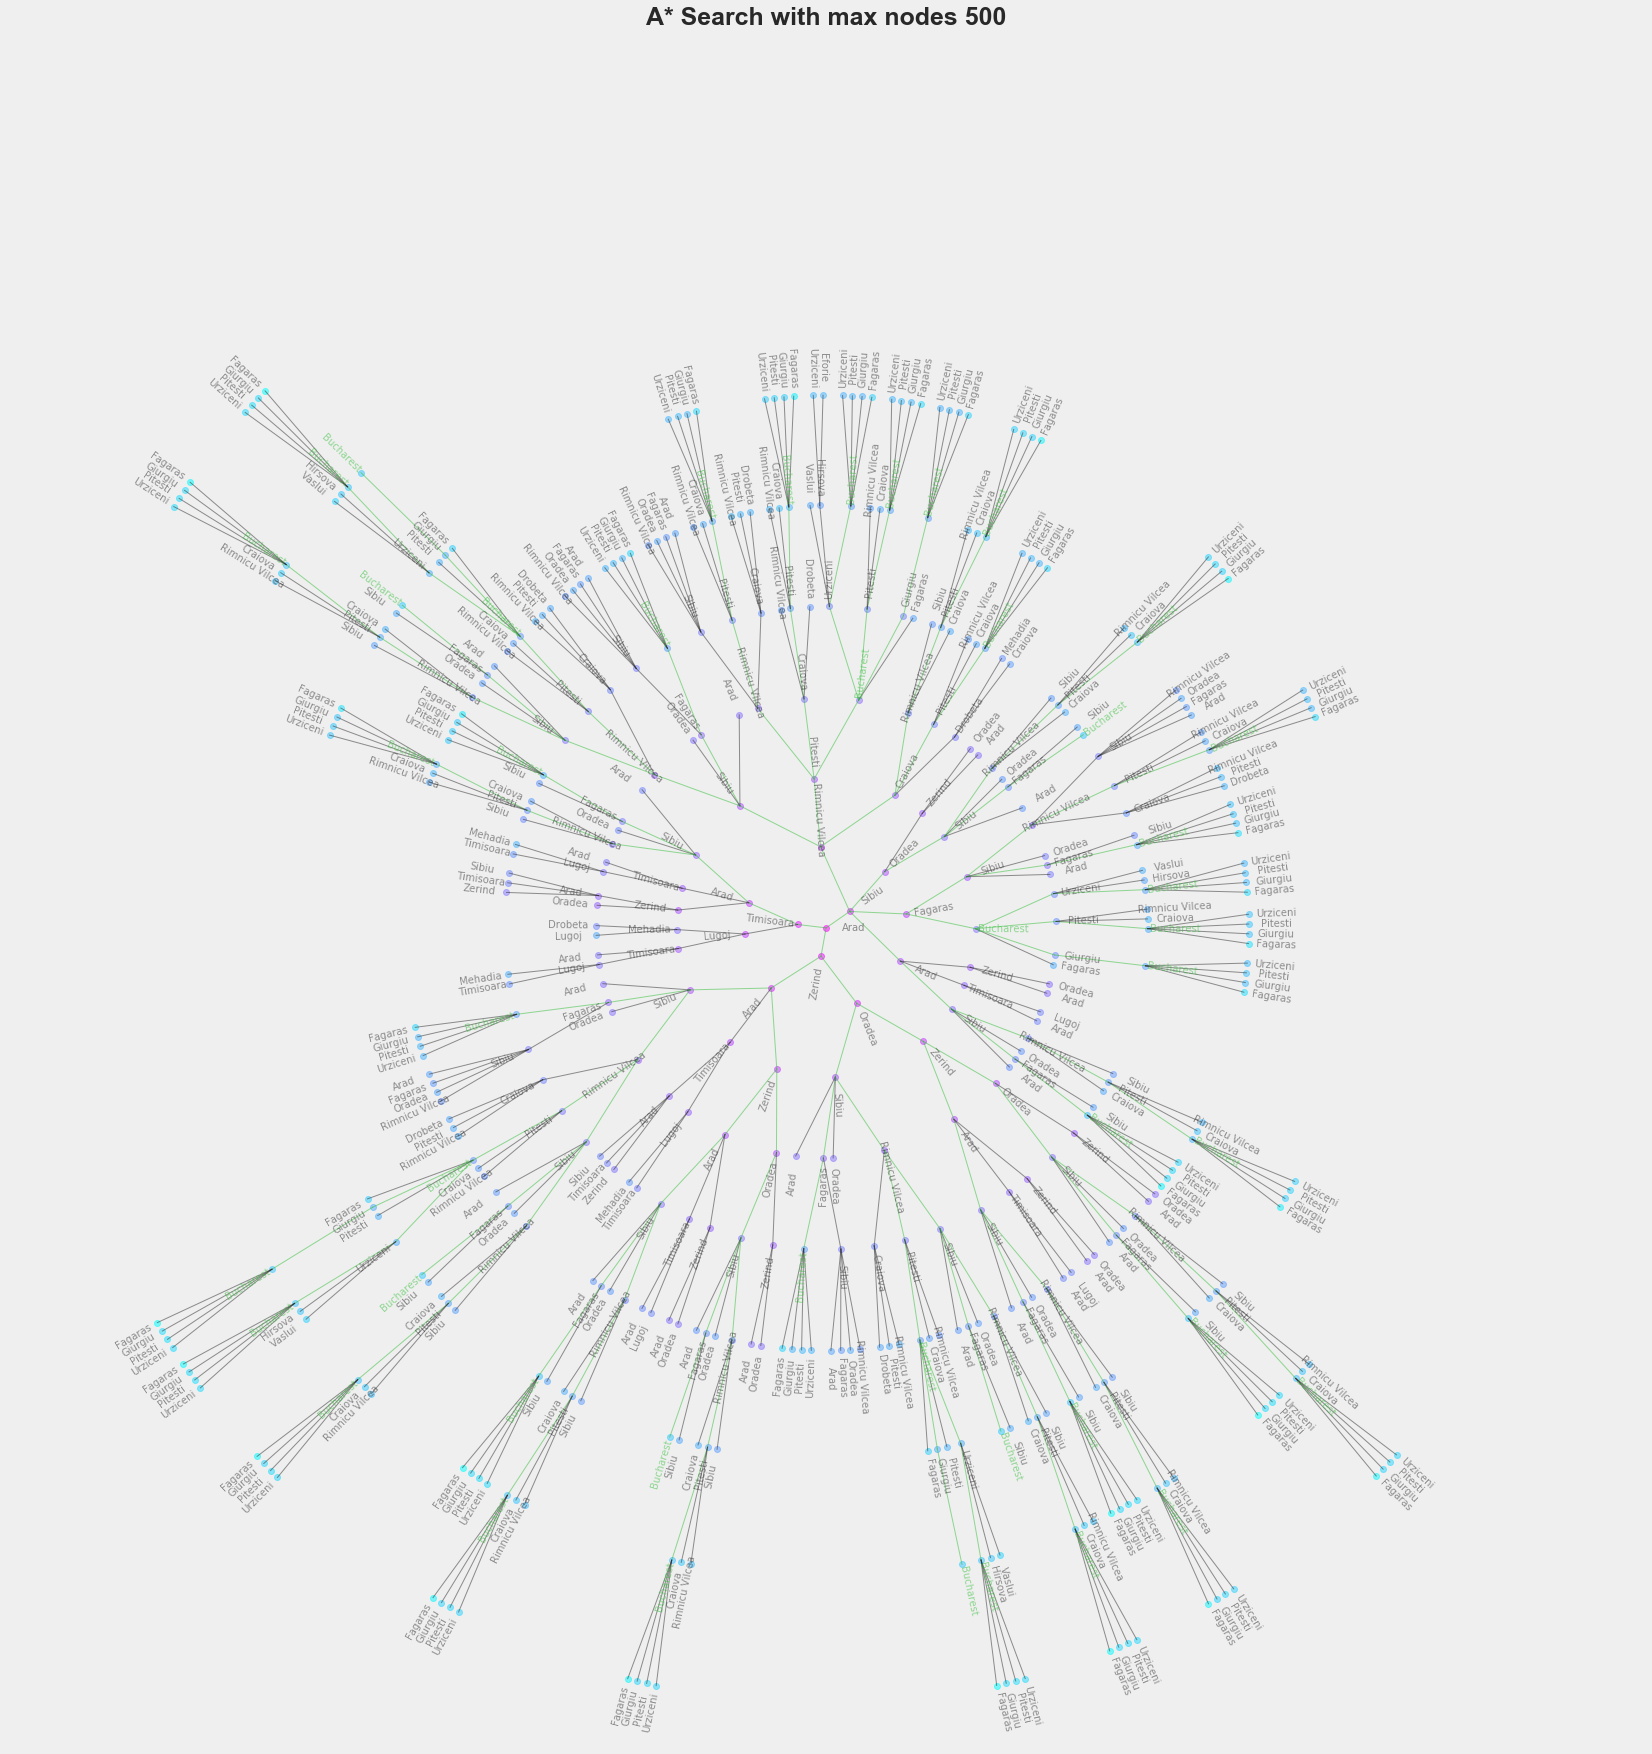

In [9]:
import json
tree  = json.load(open('results/tree.json'))
paths = json.load(open('results/paths.json'))

plot = PolarPlot(diameter=30, background='light')
plot.plot_tree(tree, paths, title='A* Search with max nodes 500')

In [10]:
plot.save('images/tree_plot.png')